In [1]:
import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from model import EmotionClassifier
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")

class_labels = ['happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

model = EmotionClassifier().to(device)
model.load_state_dict(torch.load('best_RAF.pth', map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def classify_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    image_array = np.array(image)
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
    scores = probabilities.cpu().numpy().flatten()
    rounded_scores = [round(score, 2) for score in scores]
    return rounded_scores, image, image_array, image_tensor

# test_path = 'dataset/vali/img381_happiness.jpg'
# test_path = 'dataset/vali/img005_surprise.jpg'
test_path = 'dataset/vali/img113_fear.jpg'
scores, image, image_array, image_tensor = classify_image(test_path)
print(scores)

[0.12, 0.73, 0.04, 0.02, 0.02, 0.08]


In [3]:
# approach with self defined hook functions: https://towardsdatascience.com/grad-cam-in-pytorch-use-of-forward-and-backward-hooks-7eba5e38d569
# defines two global scope variables to store our gradients and activations
gradients = None
activations = None

def backward_hook(model, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Gradients size: {gradients[0].size()}') 
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(model, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Activations size: {activations.size()}')
  
# backward_hook = model.bn5.register_full_backward_hook(backward_hook, prepend=False)
# forward_hook = model.bn5.register_forward_hook(forward_hook, prepend=False)

img_tensor = transform(image)
model(img_tensor.unsqueeze(0))
model.backward()

backward_hook.remove()
forward_hook.remove()

AttributeError: 'EmotionClassifier' object has no attribute 'backward'

In [ ]:
# approach with pytorch Grad-CAM: https://github.com/jacobgil/pytorch-grad-cam?tab=readme-ov-file

print(model.bn5)
target_layers = [model.bn5]

# convert the input image to np.float32
image_array = image_array.astype(np.float32)

# normalize the input image to the range [0, 1]
image_array /= 255.0

# Print the shape of the array
print("Shape of image array:", image_array.shape)

# construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)
print(cam)

targets = [ClassifierOutputTarget(1)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=image_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(image_array, grayscale_cam, use_rgb=True)

print(type(visualization))
print(visualization.shape)


# Overlay the second image with transparency
plt.imshow(image2, alpha=0.5)

# Hide axes
plt.axis('off')

# Show the plot
plt.show()

# Display the input image
plt.figure(figsize=(8, 8))
plt.imshow(image_array)
plt.title('Input Image')
plt.axis('off')
plt.show()

# Display the CAM visualization
plt.figure(figsize=(8, 8))
plt.imshow(visualization)
plt.title('CAM Visualization')
plt.axis('off')
plt.show()


BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Shape of image array: (64, 64, 3)
<class 'numpy.ndarray'>
(64, 64, 3)


NameError: name 'image2' is not defined

In [ ]:
# Grad-CAM with Torchcam: https://github.com/frgfm/torch-cam/blob/main/README.md

(-0.5, 1439.5, 959.5, -0.5)

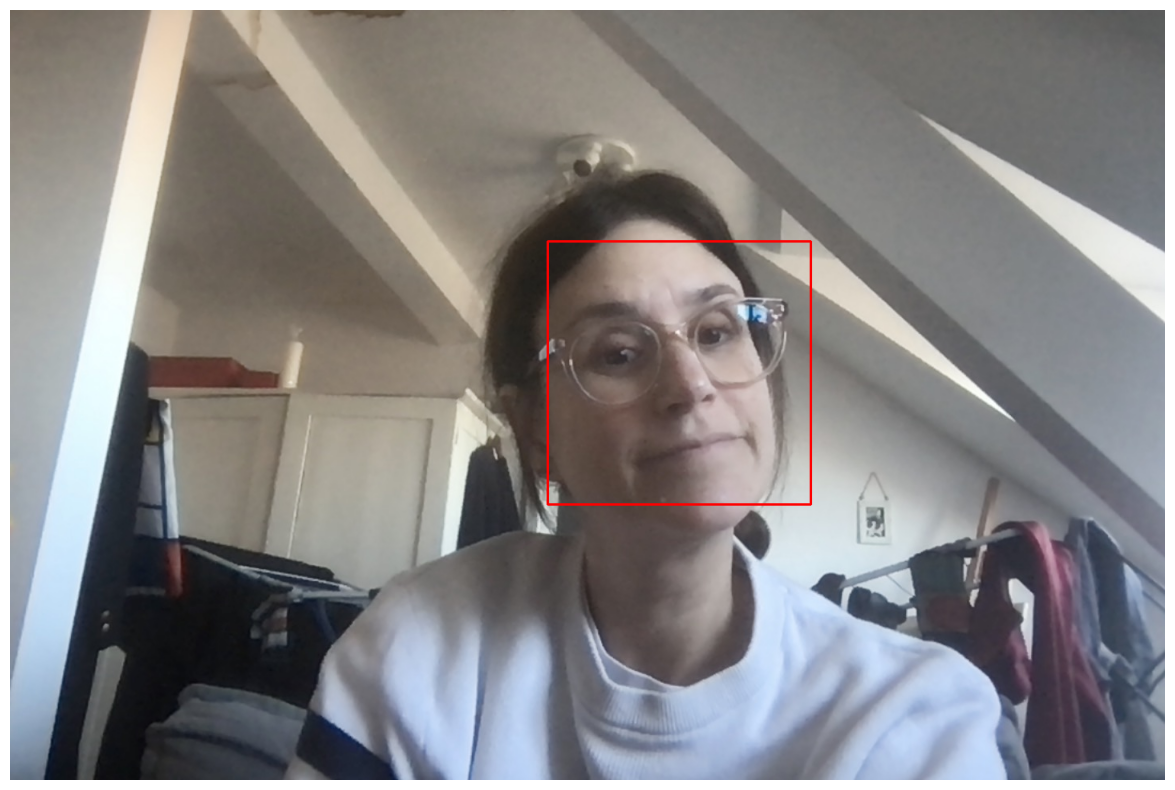

In [ ]:
# Bounding Box on Landmarks with OpenCV
# Rectangle not visibable
img = cv2.imread('test.jpg')
# img.shape
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# gray_image.shape

# load the classifier
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)
# perform face detection
face = face_classifier.detectMultiScale(
    gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40)
)
# bounding box
for (x, y, w, h) in face:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(img_rgb)
plt.axis('off')

In [4]:
# OpenCV Real-Time Face Detection

face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

# access webcam as numpy.ndarray
video_capture = cv2.VideoCapture(0)

def detect_emotion(video_frame):
    vid_fr_tensor = transform(video_frame).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(vid_fr_tensor)
        probabilities = F.softmax(outputs, dim=1)
    scores = probabilities.cpu().numpy().flatten()
    rounded_scores = [round(score, 2) for score in scores]
    return rounded_scores

# identify Face in Video Stream
def detect_bounding_box(vid):
    gray_image = cv2.cvtColor(vid, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray_image, 1.1, 5, minSize=(40, 40))
    for (x, y, w, h) in faces:
        # draw bounding box on face
        cv2.rectangle(vid, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # crop bounding box
        crop_img = vid[y : y + h, x : x + w]
        pil_crop_img = Image.fromarray(crop_img)
        rounded_scores = detect_emotion(pil_crop_img)
        
        # create text to be displayed
        emotion_evaluation_str = ''
        for index, value in enumerate(class_labels):
            emotion_evaluation_str += f'{value}: {rounded_scores[index]}\n'

        # Text settings
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_color = (255, 255, 255)  # BGR color
        thickness = 2
        line_type = cv2.LINE_AA

        # Position to put the text (top-left corner of the first line)
        org = (x + w + 10, y)

        # Calculate the height of the text
        (height, _) = cv2.getTextSize(emotion_evaluation_str, font, font_scale, thickness)[0]

        # Split the multiline text into individual lines
        lines = emotion_evaluation_str.split('\n')

        # Put each line of text on the image
        for i, line in enumerate(lines):
            # Calculate the position for this line
            y = org[1] + i * height

            # Put the text on the image
            cv2.putText(vid, line, (org[0], y), font, font_scale, font_color, thickness, line_type)

        
        # draw rounded_scores on vid
        # cv2.putText(vid, emotion_evaluation_str, (x + w + 10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        # print(rounded_scores)
    return faces

# Loop for Real-Time Face Detection
while True:

    result, video_frame = video_capture.read()  # read frames from the video
    if result is False:
        break  # terminate the loop if the frame is not read successfully
    # print(type(video_frame))
    
    faces = detect_bounding_box(
        video_frame
    )  # apply the function we created to the video frame

    cv2.imshow(
        "My Face Detection Project", video_frame
    )  # display the processed frame in a window named "My Face Detection Project"

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

video_capture.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 